# Operational Analysis

Delivery performance, SLA compliance, ratings trends, and restaurant performance analysis.

## Setup

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('/home/parambrata-ghosh/Development/Personal/Projects/Food_Delivery_Startup/input/RPC_18_Datasets')
OUTPUT_DIR = Path('/home/parambrata-ghosh/Development/Personal/Projects/Food_Delivery_Startup/output')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Load Data

In [8]:
df_orders = pd.read_csv(DATA_DIR / 'fact_orders.csv')
df_delivery = pd.read_csv(DATA_DIR / 'fact_delivery_performance.csv')
df_ratings = pd.read_csv(DATA_DIR / 'fact_ratings.csv')
df_restaurant = pd.read_csv(DATA_DIR / 'dim_restaurant.csv')
df_customer = pd.read_csv(DATA_DIR / 'dim_customer.csv')

# Convert dates
df_orders['order_timestamp'] = pd.to_datetime(df_orders['order_timestamp'])
df_ratings['review_timestamp'] = pd.to_datetime(df_ratings['review_timestamp'], format='%d-%m-%Y %H:%M')

# Add time columns
df_orders['month'] = df_orders['order_timestamp'].dt.month
df_orders['year'] = df_orders['order_timestamp'].dt.year
df_orders['month_period'] = df_orders['order_timestamp'].dt.to_period('M')

df_ratings['month'] = df_ratings['review_timestamp'].dt.month
df_ratings['year'] = df_ratings['review_timestamp'].dt.year
df_ratings['month_period'] = df_ratings['review_timestamp'].dt.to_period('M')

print(f"Loaded {len(df_orders):,} orders")
print(f"Loaded {len(df_delivery):,} delivery records")
print(f"Loaded {len(df_ratings):,} ratings")
print(f"Loaded {len(df_restaurant):,} restaurants")

Loaded 149,166 orders
Loaded 149,166 delivery records
Loaded 68,842 ratings
Loaded 19,995 restaurants


## Q5: Delivery SLA Compliance

In [9]:
# Merge delivery performance with orders
df_delivery_analysis = df_orders.merge(df_delivery, on='order_id', how='inner')

# Calculate SLA violation
df_delivery_analysis['sla_violation'] = (
    df_delivery_analysis['actual_delivery_time_mins'] > 
    df_delivery_analysis['expected_delivery_time_mins']
)

df_delivery_analysis['delay_mins'] = (
    df_delivery_analysis['actual_delivery_time_mins'] - 
    df_delivery_analysis['expected_delivery_time_mins']
)

# Overall SLA compliance
total_deliveries = len(df_delivery_analysis)
sla_violations = df_delivery_analysis['sla_violation'].sum()
sla_compliance_rate = ((total_deliveries - sla_violations) / total_deliveries) * 100

print("DELIVERY SLA COMPLIANCE")
print("=" * 60)
print(f"Total Deliveries: {total_deliveries:,}")
print(f"On-Time Deliveries: {total_deliveries - sla_violations:,}")
print(f"Late Deliveries: {sla_violations:,}")
print(f"SLA Compliance Rate: {sla_compliance_rate:.2f}%")
print(f"\nAvg Actual Delivery Time: {df_delivery_analysis['actual_delivery_time_mins'].mean():.1f} mins")
print(f"Avg Expected Delivery Time: {df_delivery_analysis['expected_delivery_time_mins'].mean():.1f} mins")
print(f"Avg Delay (for late orders): {df_delivery_analysis[df_delivery_analysis['sla_violation']]['delay_mins'].mean():.1f} mins")

DELIVERY SLA COMPLIANCE
Total Deliveries: 149,166
On-Time Deliveries: 53,940
Late Deliveries: 95,226
SLA Compliance Rate: 36.16%

Avg Actual Delivery Time: 44.4 mins
Avg Expected Delivery Time: 38.7 mins
Avg Delay (for late orders): 12.3 mins
Avg Delay (for late orders): 12.3 mins


In [10]:
# Monthly SLA compliance
monthly_sla = df_delivery_analysis.groupby('month_period').agg({
    'sla_violation': ['count', 'sum'],
    'actual_delivery_time_mins': 'mean',
    'expected_delivery_time_mins': 'mean',
    'delay_mins': 'mean'
}).reset_index()

monthly_sla.columns = ['month_period', 'total_orders', 'late_orders', 'avg_actual_time', 'avg_expected_time', 'avg_delay']
monthly_sla['compliance_rate'] = ((monthly_sla['total_orders'] - monthly_sla['late_orders']) / monthly_sla['total_orders']) * 100
monthly_sla['month_period'] = monthly_sla['month_period'].astype(str)

print(f"\nMONTHLY SLA COMPLIANCE")
print("=" * 80)
print(monthly_sla.to_string(index=False))

# Pre-crisis vs crisis comparison
pre_crisis = df_delivery_analysis[(df_delivery_analysis['year'] == 2025) & (df_delivery_analysis['month'].between(1, 5))]
crisis = df_delivery_analysis[(df_delivery_analysis['year'] == 2025) & (df_delivery_analysis['month'].between(6, 9))]

pre_crisis_compliance = ((len(pre_crisis) - pre_crisis['sla_violation'].sum()) / len(pre_crisis)) * 100
crisis_compliance = ((len(crisis) - crisis['sla_violation'].sum()) / len(crisis)) * 100

print(f"\nPRE-CRISIS VS CRISIS COMPARISON")
print("=" * 60)
print(f"Pre-Crisis Compliance: {pre_crisis_compliance:.2f}%")
print(f"Crisis Compliance: {crisis_compliance:.2f}%")
print(f"Change: {crisis_compliance - pre_crisis_compliance:+.2f} pp")


MONTHLY SLA COMPLIANCE
month_period  total_orders  late_orders  avg_actual_time  avg_expected_time  avg_delay  compliance_rate
     2025-01         23539        13365        39.576065          37.496623   2.079443        43.221887
     2025-02         22667        12701        39.503463          37.528566   1.974897        43.967000
     2025-03         23543        13116        39.392728          37.527121   1.865608        44.289173
     2025-04         21466        12153        39.571182          37.481366   2.089816        43.384888
     2025-05         22591        12846        39.574388          37.479749   2.094639        43.136647
     2025-06          9293         8197        60.310341          42.488432  17.821909        11.793823
     2025-07          8818         7711        59.946246          42.491948  17.454298        12.553867
     2025-08          8555         7499        60.059264          42.549620  17.509643        12.343659
     2025-09          8694         7638 

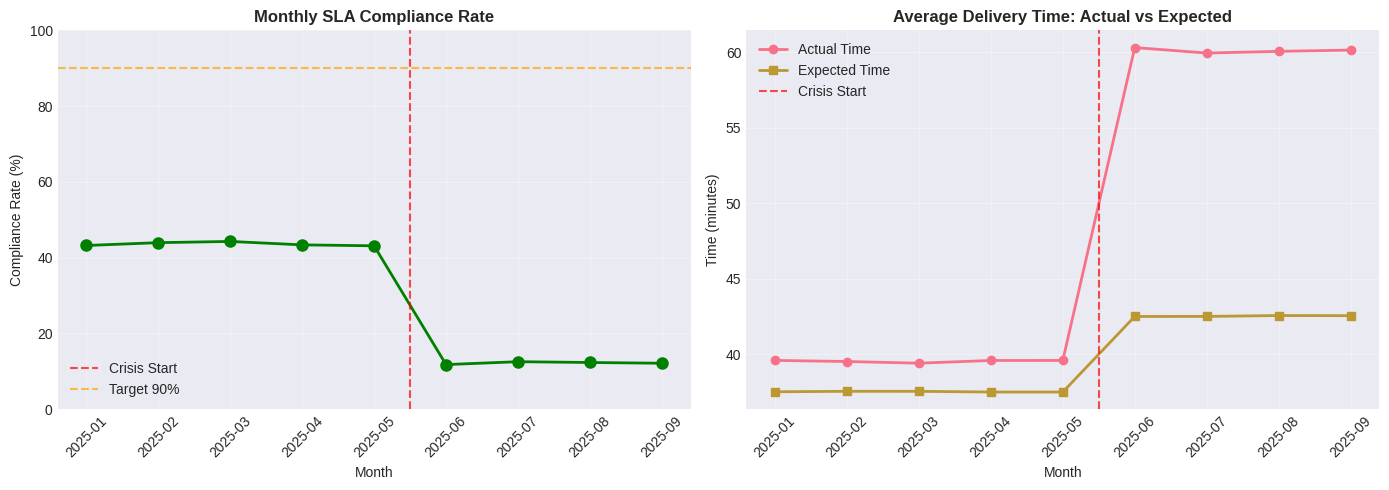

In [11]:
# Visualize SLA compliance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Monthly compliance rate
ax1.plot(monthly_sla['month_period'], monthly_sla['compliance_rate'], marker='o', linewidth=2, markersize=8, color='green')
ax1.axvline(x=4.5, color='red', linestyle='--', alpha=0.7, label='Crisis Start')
ax1.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='Target 90%')
ax1.set_xlabel('Month')
ax1.set_ylabel('Compliance Rate (%)')
ax1.set_title('Monthly SLA Compliance Rate', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim(0, 100)

# Delivery time comparison
ax2.plot(monthly_sla['month_period'], monthly_sla['avg_actual_time'], marker='o', label='Actual Time', linewidth=2)
ax2.plot(monthly_sla['month_period'], monthly_sla['avg_expected_time'], marker='s', label='Expected Time', linewidth=2)
ax2.axvline(x=4.5, color='red', linestyle='--', alpha=0.7, label='Crisis Start')
ax2.set_xlabel('Month')
ax2.set_ylabel('Time (minutes)')
ax2.set_title('Average Delivery Time: Actual vs Expected', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## Q6: Ratings Fluctuation Analysis

In [12]:
# Clean ratings data (remove nulls)
df_ratings_clean = df_ratings.dropna()

# Overall rating statistics
overall_avg_rating = df_ratings_clean['rating'].mean()

print("OVERALL RATING STATISTICS")
print("=" * 60)
print(f"Total Ratings: {len(df_ratings_clean):,}")
print(f"Average Overall Rating: {overall_avg_rating:.2f}/5")

# Rating distribution
rating_dist = df_ratings_clean['rating'].value_counts().sort_index()
print(f"\nRating Distribution:")
for rating, count in rating_dist.items():
    print(f"  {rating}: {count:,} ({count/len(df_ratings_clean)*100:.1f}%)")

OVERALL RATING STATISTICS
Total Ratings: 68,825
Average Overall Rating: 4.05/5

Rating Distribution:
  1.0: 160 (0.2%)
  1.1: 90 (0.1%)
  1.2: 106 (0.2%)
  1.3: 148 (0.2%)
  1.4: 182 (0.3%)
  1.5: 269 (0.4%)
  1.6: 334 (0.5%)
  1.7: 467 (0.7%)
  1.8: 525 (0.8%)
  1.9: 609 (0.9%)
  2.0: 723 (1.1%)
  2.1: 820 (1.2%)
  2.2: 943 (1.4%)
  2.3: 968 (1.4%)
  2.4: 996 (1.4%)
  2.5: 999 (1.5%)
  2.6: 982 (1.4%)
  2.7: 912 (1.3%)
  2.8: 878 (1.3%)
  2.9: 782 (1.1%)
  3.0: 670 (1.0%)
  3.1: 622 (0.9%)
  3.2: 579 (0.8%)
  3.3: 464 (0.7%)
  3.4: 396 (0.6%)
  3.5: 429 (0.6%)
  3.6: 570 (0.8%)
  3.7: 786 (1.1%)
  3.8: 1,120 (1.6%)
  3.9: 1,615 (2.3%)
  4.0: 2,214 (3.2%)
  4.1: 3,166 (4.6%)
  4.2: 3,828 (5.6%)
  4.3: 4,602 (6.7%)
  4.4: 5,268 (7.7%)
  4.5: 5,446 (7.9%)
  4.6: 5,152 (7.5%)
  4.7: 4,915 (7.1%)
  4.8: 4,228 (6.1%)
  4.9: 3,438 (5.0%)
  5.0: 7,424 (10.8%)


In [13]:
# Monthly rating trends
monthly_ratings = df_ratings_clean.groupby('month_period').agg({
    'rating': ['count', 'mean']
}).reset_index()

monthly_ratings.columns = ['month_period', 'count', 'avg_rating']
monthly_ratings['month_period'] = monthly_ratings['month_period'].astype(str)

print(f"\nMONTHLY RATING TRENDS")
print("=" * 80)
print(monthly_ratings.to_string(index=False))

# Pre-crisis vs crisis comparison
pre_crisis_ratings = df_ratings_clean[(df_ratings_clean['year'] == 2025) & (df_ratings_clean['month'].between(1, 5))]
crisis_ratings = df_ratings_clean[(df_ratings_clean['year'] == 2025) & (df_ratings_clean['month'].between(6, 9))]

print(f"\nPRE-CRISIS VS CRISIS COMPARISON")
print("=" * 60)
print(f"Pre-Crisis Avg Rating: {pre_crisis_ratings['rating'].mean():.2f}")
print(f"Crisis Avg Rating: {crisis_ratings['rating'].mean():.2f}")
print(f"Change: {crisis_ratings['rating'].mean() - pre_crisis_ratings['rating'].mean():+.2f}")


MONTHLY RATING TRENDS
month_period  count  avg_rating
     2025-01  10939    4.576351
     2025-02  10588    4.399887
     2025-03  10971    4.737654
     2025-04  10141    4.297022
     2025-05  10605    4.488336
     2025-06   4165    2.625666
     2025-07   3880    2.689794
     2025-08   3668    2.402017
     2025-09   3868    2.305791

PRE-CRISIS VS CRISIS COMPARISON
Pre-Crisis Avg Rating: 4.50
Crisis Avg Rating: 2.51
Change: -1.99


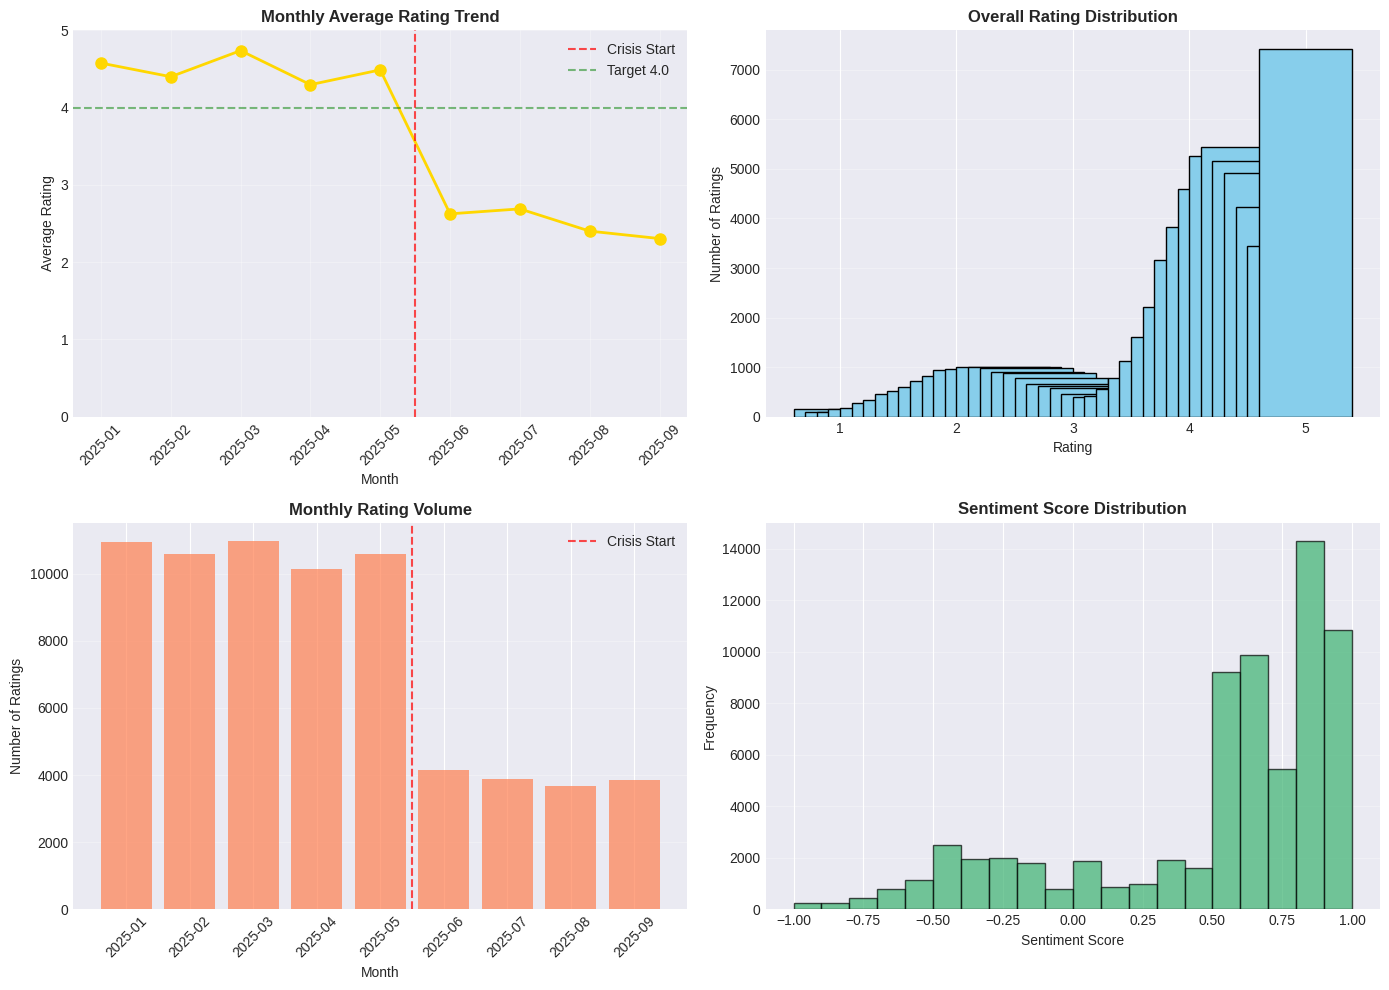

In [14]:
# Visualize rating trends
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overall rating trend
axes[0, 0].plot(monthly_ratings['month_period'], monthly_ratings['avg_rating'], marker='o', linewidth=2, markersize=8, color='gold')
axes[0, 0].axvline(x=4.5, color='red', linestyle='--', alpha=0.7, label='Crisis Start')
axes[0, 0].axhline(y=4.0, color='green', linestyle='--', alpha=0.5, label='Target 4.0')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Average Rating')
axes[0, 0].set_title('Monthly Average Rating Trend', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 5)

# Rating distribution
rating_counts = df_ratings_clean['rating'].value_counts().sort_index()
axes[0, 1].bar(rating_counts.index, rating_counts.values, color='skyblue', edgecolor='black')
axes[0, 1].set_xlabel('Rating')
axes[0, 1].set_ylabel('Number of Ratings')
axes[0, 1].set_title('Overall Rating Distribution', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Monthly rating count
axes[1, 0].bar(monthly_ratings['month_period'], monthly_ratings['count'], color='coral', alpha=0.7)
axes[1, 0].axvline(x=4.5, color='red', linestyle='--', alpha=0.7, label='Crisis Start')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Number of Ratings')
axes[1, 0].set_title('Monthly Rating Volume', fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].legend()

# Sentiment score distribution
axes[1, 1].hist(df_ratings_clean['sentiment_score'], bins=20, color='mediumseagreen', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Sentiment Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Sentiment Score Distribution', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Q7: Sentiment Analysis from Reviews

In [15]:
# Categorize sentiment based on rating
def categorize_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df_ratings_clean['sentiment'] = df_ratings_clean['rating'].apply(categorize_sentiment)

# Overall sentiment distribution
sentiment_dist = df_ratings_clean['sentiment'].value_counts()

print("SENTIMENT ANALYSIS")
print("=" * 60)
print(f"Sentiment Distribution:")
for sentiment, count in sentiment_dist.items():
    print(f"  {sentiment}: {count:,} ({count/len(df_ratings_clean)*100:.1f}%)")

# Sentiment by period
pre_crisis_sentiment = pre_crisis_ratings['rating'].apply(categorize_sentiment).value_counts()
crisis_sentiment = crisis_ratings['rating'].apply(categorize_sentiment).value_counts()

print(f"\nPRE-CRISIS SENTIMENT")
print("=" * 40)
for sentiment in ['Positive', 'Neutral', 'Negative']:
    count = pre_crisis_sentiment.get(sentiment, 0)
    print(f"  {sentiment}: {count:,} ({count/len(pre_crisis_ratings)*100:.1f}%)")

print(f"\nCRISIS SENTIMENT")
print("=" * 40)
for sentiment in ['Positive', 'Neutral', 'Negative']:
    count = crisis_sentiment.get(sentiment, 0)
    print(f"  {sentiment}: {count:,} ({count/len(crisis_ratings)*100:.1f}%)")

SENTIMENT ANALYSIS
Sentiment Distribution:
  Positive: 49,681 (72.2%)
  Negative: 18,474 (26.8%)
  Neutral: 670 (1.0%)

PRE-CRISIS SENTIMENT
  Positive: 49,457 (92.9%)
  Neutral: 1 (0.0%)
  Negative: 3,786 (7.1%)

CRISIS SENTIMENT
  Positive: 224 (1.4%)
  Neutral: 669 (4.3%)
  Negative: 14,688 (94.3%)


In [16]:
# Extract common words from review text (simplified word frequency)
review_text_all = ' '.join(df_ratings_clean['review_text'].astype(str).str.lower())

# Remove common stop words and split
stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'is', 'was', 'were', 'are', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'can', 'it', 'its', 'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'they', 'we', 'my', 'your', 'his', 'her', 'their', 'our'}

words = review_text_all.split()
filtered_words = [word for word in words if word not in stop_words and len(word) > 3]
word_freq = Counter(filtered_words).most_common(20)

print(f"\nTOP 20 MOST COMMON WORDS IN REVIEWS")
print("=" * 60)
for word, freq in word_freq:
    print(f"  {word}: {freq:,}")


TOP 20 MOST COMMON WORDS IN REVIEWS
  great: 6,987
  good: 6,717
  service: 6,320
  fresh: 6,257
  delicious: 6,257
  excellent: 6,193
  loved: 6,119
  food: 6,099
  super: 6,064
  fast: 6,064
  delivery: 6,064
  taste!: 5,970
  experience: 5,655
  late: 5,649
  hotter: 4,814
  improve: 4,755
  tasty: 4,745
  satisfied: 4,666
  overall: 4,666
  okay: 4,618


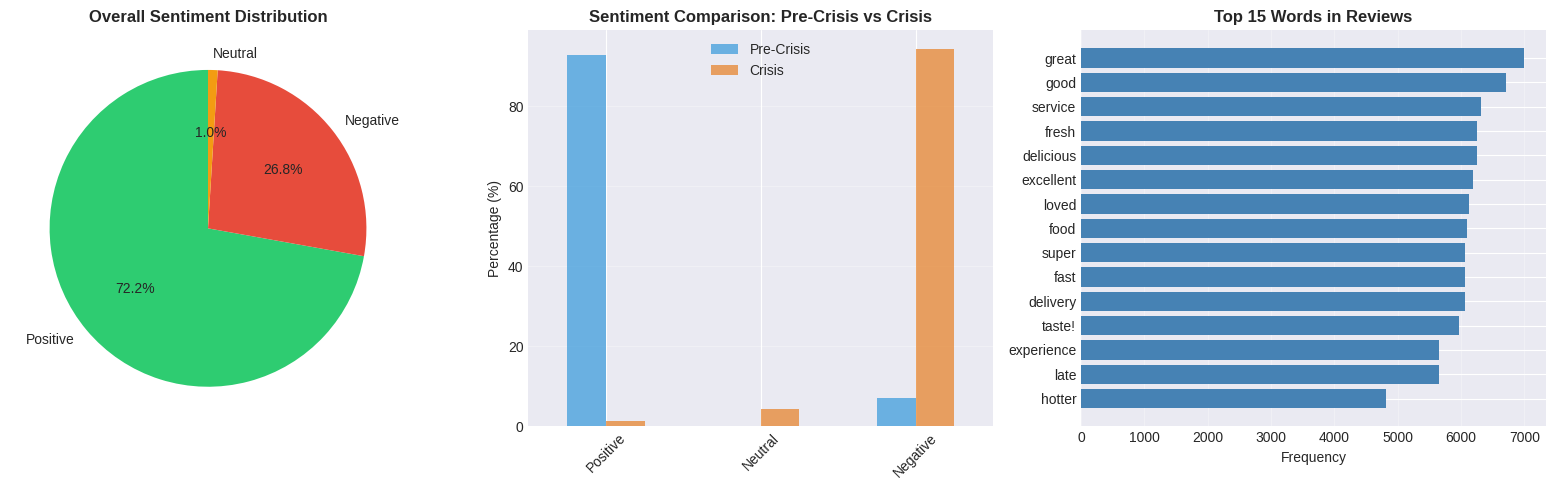

In [17]:
# Visualize sentiment analysis
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Overall sentiment pie
sentiment_colors = {'Positive': '#2ecc71', 'Neutral': '#f39c12', 'Negative': '#e74c3c'}
colors = [sentiment_colors[s] for s in sentiment_dist.index]
axes[0].pie(sentiment_dist.values, labels=sentiment_dist.index, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Overall Sentiment Distribution', fontweight='bold')

# Pre-crisis vs Crisis sentiment
sentiment_comparison = pd.DataFrame({
    'Pre-Crisis': [pre_crisis_sentiment.get(s, 0)/len(pre_crisis_ratings)*100 for s in ['Positive', 'Neutral', 'Negative']],
    'Crisis': [crisis_sentiment.get(s, 0)/len(crisis_ratings)*100 for s in ['Positive', 'Neutral', 'Negative']]
}, index=['Positive', 'Neutral', 'Negative'])

sentiment_comparison.plot(kind='bar', ax=axes[1], color=['#3498db', '#e67e22'], alpha=0.7)
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Sentiment Comparison: Pre-Crisis vs Crisis', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Top words bar chart
words_list, freq_list = zip(*word_freq[:15])
axes[2].barh(range(len(words_list)), freq_list, color='steelblue')
axes[2].set_yticks(range(len(words_list)))
axes[2].set_yticklabels(words_list)
axes[2].set_xlabel('Frequency')
axes[2].set_title('Top 15 Words in Reviews', fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='x')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

## Q3: Restaurant Performance Analysis

In [18]:
# Merge orders with restaurant info
df_orders_restaurants = df_orders[df_orders['is_cancelled'] == 'N'].merge(
    df_restaurant[['restaurant_id', 'cuisine_type']], 
    on='restaurant_id'
)

# Calculate pre-crisis and crisis orders by restaurant
pre_crisis_orders = df_orders_restaurants[
    (df_orders_restaurants['year'] == 2025) & 
    (df_orders_restaurants['month'].between(1, 5))
]
crisis_orders = df_orders_restaurants[
    (df_orders_restaurants['year'] == 2025) & 
    (df_orders_restaurants['month'].between(6, 9))
]

# Restaurant performance
restaurant_pre = pre_crisis_orders.groupby('restaurant_id').agg({
    'order_id': 'count',
    'total_amount': 'sum'
})

restaurant_crisis = crisis_orders.groupby('restaurant_id').agg({
    'order_id': 'count',
    'total_amount': 'sum'
})

restaurant_performance = pd.DataFrame({
    'pre_crisis_orders': restaurant_pre['order_id'],
    'pre_crisis_revenue': restaurant_pre['total_amount'],
    'crisis_orders': restaurant_crisis['order_id'],
    'crisis_revenue': restaurant_crisis['total_amount']
}).fillna(0)

restaurant_performance['order_change'] = restaurant_performance['crisis_orders'] - restaurant_performance['pre_crisis_orders']
restaurant_performance['order_change_pct'] = ((restaurant_performance['crisis_orders'] - restaurant_performance['pre_crisis_orders']) / restaurant_performance['pre_crisis_orders'] * 100).replace([np.inf, -np.inf], 0)
restaurant_performance['revenue_change_pct'] = ((restaurant_performance['crisis_revenue'] - restaurant_performance['pre_crisis_revenue']) / restaurant_performance['pre_crisis_revenue'] * 100).replace([np.inf, -np.inf], 0)

# Filter restaurants with at least 10 pre-crisis orders
significant_restaurants = restaurant_performance[restaurant_performance['pre_crisis_orders'] >= 10]

print("RESTAURANT PERFORMANCE ANALYSIS")
print("=" * 80)
print(f"Total Restaurants Analyzed: {len(significant_restaurants):,}")
print(f"\nTOP 10 DECLINING RESTAURANTS (by order change %)")
print("=" * 80)
top_declining = significant_restaurants.nsmallest(10, 'order_change_pct')
print(top_declining[['pre_crisis_orders', 'crisis_orders', 'order_change_pct']].to_string())

RESTAURANT PERFORMANCE ANALYSIS
Total Restaurants Analyzed: 944

TOP 10 DECLINING RESTAURANTS (by order change %)
               pre_crisis_orders  crisis_orders  order_change_pct
restaurant_id                                                    
REST00108                   11.0            0.0            -100.0
REST00140                   10.0            0.0            -100.0
REST00185                   11.0            0.0            -100.0
REST00231                   10.0            0.0            -100.0
REST00274                   10.0            0.0            -100.0
REST00295                   14.0            0.0            -100.0
REST00304                   14.0            0.0            -100.0
REST00367                   12.0            0.0            -100.0
REST00411                   12.0            0.0            -100.0
REST00826                   10.0            0.0            -100.0


In [19]:
# Cuisine type performance
cuisine_pre = pre_crisis_orders.groupby('cuisine_type').size()
cuisine_crisis = crisis_orders.groupby('cuisine_type').size()

cuisine_performance = pd.DataFrame({
    'pre_crisis': cuisine_pre,
    'crisis': cuisine_crisis
}).fillna(0)

cuisine_performance['change_pct'] = ((cuisine_performance['crisis'] - cuisine_performance['pre_crisis']) / cuisine_performance['pre_crisis'] * 100)
cuisine_performance = cuisine_performance.sort_values('change_pct')

print(f"\nCUISINE TYPE PERFORMANCE")
print("=" * 80)
print(cuisine_performance.to_string())

print(f"\nMOST AFFECTED CUISINES:")
for idx, (cuisine, row) in enumerate(cuisine_performance.head(3).iterrows(), 1):
    print(f"  {idx}. {cuisine}: {row['change_pct']:.1f}% decline")

print(f"\nBEST PERFORMING CUISINES:")
for idx, (cuisine, row) in enumerate(cuisine_performance.tail(3).iterrows(), 1):
    print(f"  {idx}. {cuisine}: {row['change_pct']:+.1f}%")


CUISINE TYPE PERFORMANCE
              pre_crisis  crisis  change_pct
cuisine_type                                
Desserts            8753    2443  -72.089569
Healthy             5438    1561  -71.294594
South Indian       16123    4658  -71.109595
Pizza              13212    3840  -70.935513
North Indian       21075    6166  -70.742586
Fast Food          10416    3054  -70.679724
Biryani            16136    4748  -70.575112
Chinese            15759    4672  -70.353449

MOST AFFECTED CUISINES:
  1. Desserts: -72.1% decline
  2. Healthy: -71.3% decline
  3. South Indian: -71.1% decline

BEST PERFORMING CUISINES:
  1. Fast Food: -70.7%
  2. Biryani: -70.6%
  3. Chinese: -70.4%


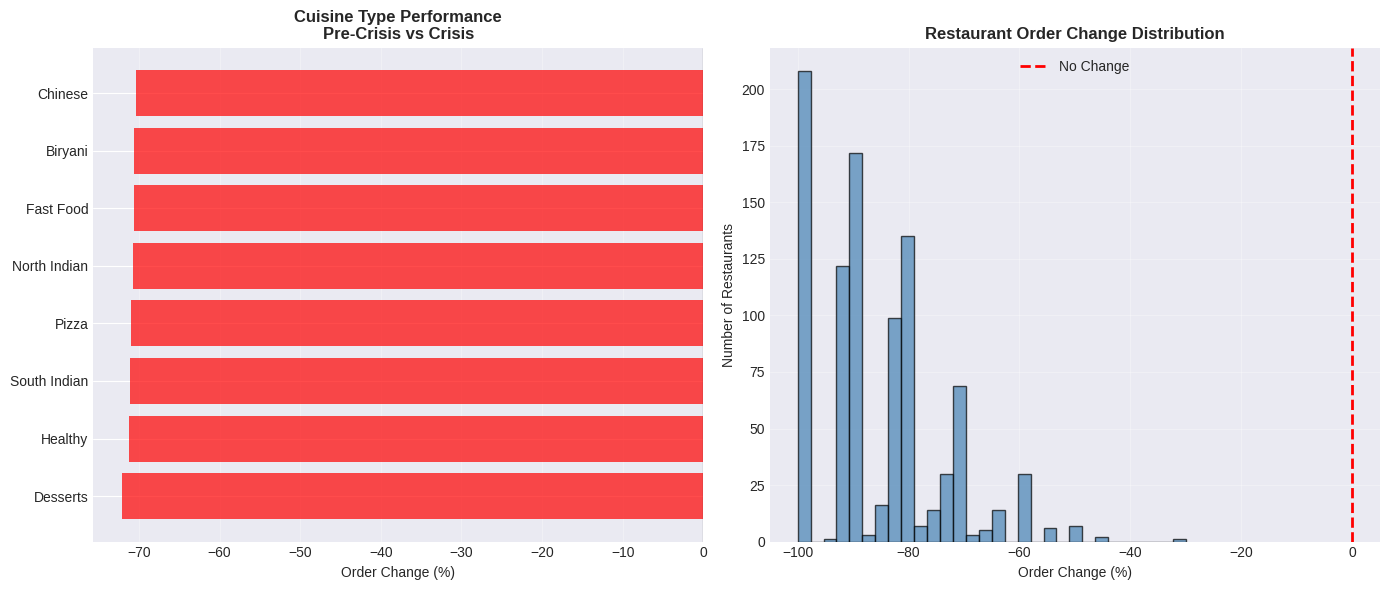

In [20]:
# Visualize restaurant performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Cuisine performance
colors = ['red' if x < 0 else 'green' for x in cuisine_performance['change_pct']]
ax1.barh(cuisine_performance.index, cuisine_performance['change_pct'], color=colors, alpha=0.7)
ax1.set_xlabel('Order Change (%)')
ax1.set_title('Cuisine Type Performance\nPre-Crisis vs Crisis', fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax1.grid(True, alpha=0.3, axis='x')

# Restaurant order change distribution
ax2.hist(significant_restaurants['order_change_pct'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Change')
ax2.set_xlabel('Order Change (%)')
ax2.set_ylabel('Number of Restaurants')
ax2.set_title('Restaurant Order Change Distribution', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Insights Summary

In [21]:
print("\n" + "=" * 80)
print("OPERATIONAL ANALYSIS - EXECUTIVE SUMMARY")
print("=" * 80)

print(f"\nDELIVERY PERFORMANCE (Q5)")
print(f"  • Overall SLA Compliance: {sla_compliance_rate:.2f}%")
print(f"  • Pre-Crisis Compliance: {pre_crisis_compliance:.2f}%")
print(f"  • Crisis Compliance: {crisis_compliance:.2f}%")
print(f"  • Change: {crisis_compliance - pre_crisis_compliance:+.2f} pp")
print(f"  • Avg Delay (late orders): {df_delivery_analysis[df_delivery_analysis['sla_violation']]['delay_mins'].mean():.1f} mins")

print(f"\nRATINGS ANALYSIS (Q6)")
print(f"  • Overall Avg Rating: {overall_avg_rating:.2f}/5")
print(f"  • Pre-Crisis Rating: {pre_crisis_ratings['rating'].mean():.2f}/5")
print(f"  • Crisis Rating: {crisis_ratings['rating'].mean():.2f}/5")
print(f"  • Change: {crisis_ratings['rating'].mean() - pre_crisis_ratings['rating'].mean():+.2f}")

print(f"\nSENTIMENT ANALYSIS (Q7)")
positive_pct = sentiment_dist.get('Positive', 0) / len(df_ratings_clean) * 100
negative_pct = sentiment_dist.get('Negative', 0) / len(df_ratings_clean) * 100
print(f"  • Positive Sentiment: {positive_pct:.1f}%")
print(f"  • Negative Sentiment: {negative_pct:.1f}%")
pre_positive = pre_crisis_sentiment.get('Positive', 0) / len(pre_crisis_ratings) * 100
crisis_positive = crisis_sentiment.get('Positive', 0) / len(crisis_ratings) * 100
print(f"  • Positive Change: {crisis_positive - pre_positive:+.1f} pp")

print(f"\nRESTAURANT PERFORMANCE (Q3)")
print(f"  • Restaurants Analyzed: {len(significant_restaurants):,}")
print(f"  • Most Declining Cuisine: {cuisine_performance.index[0]} ({cuisine_performance.iloc[0]['change_pct']:.1f}%)")
print(f"  • Best Performing Cuisine: {cuisine_performance.index[-1]} ({cuisine_performance.iloc[-1]['change_pct']:+.1f}%)")
print(f"  • Avg Restaurant Order Change: {significant_restaurants['order_change_pct'].mean():.1f}%")

print("\n" + "=" * 80)


OPERATIONAL ANALYSIS - EXECUTIVE SUMMARY

DELIVERY PERFORMANCE (Q5)
  • Overall SLA Compliance: 36.16%
  • Pre-Crisis Compliance: 43.60%
  • Crisis Compliance: 12.20%
  • Change: -31.40 pp
  • Avg Delay (late orders): 12.3 mins

RATINGS ANALYSIS (Q6)
  • Overall Avg Rating: 4.05/5
  • Pre-Crisis Rating: 4.50/5
  • Crisis Rating: 2.51/5
  • Change: -1.99

SENTIMENT ANALYSIS (Q7)
  • Positive Sentiment: 72.2%
  • Negative Sentiment: 26.8%
  • Positive Change: -91.4 pp

RESTAURANT PERFORMANCE (Q3)
  • Restaurants Analyzed: 944
  • Most Declining Cuisine: Desserts (-72.1%)
  • Best Performing Cuisine: Chinese (-70.4%)
  • Avg Restaurant Order Change: -85.5%



## Export for Dashboard

In [22]:
OUTPUT_DIR.mkdir(exist_ok=True)

# Export operational metrics
monthly_sla.to_csv(OUTPUT_DIR / 'monthly_sla_compliance.csv', index=False)
monthly_ratings.to_csv(OUTPUT_DIR / 'monthly_ratings.csv', index=False)
df_ratings_clean[['rating', 'sentiment']].to_csv(OUTPUT_DIR / 'sentiment_analysis.csv', index=False)
significant_restaurants.to_csv(OUTPUT_DIR / 'restaurant_performance.csv')
cuisine_performance.to_csv(OUTPUT_DIR / 'cuisine_performance.csv')

# Export word frequency
word_freq_df = pd.DataFrame(word_freq, columns=['word', 'frequency'])
word_freq_df.to_csv(OUTPUT_DIR / 'review_word_frequency.csv', index=False)

print("Exported files for dashboard:")
print("  • monthly_sla_compliance.csv")
print("  • monthly_ratings.csv")
print("  • sentiment_analysis.csv")
print("  • restaurant_performance.csv")
print("  • cuisine_performance.csv")
print("  • review_word_frequency.csv")

Exported files for dashboard:
  • monthly_sla_compliance.csv
  • monthly_ratings.csv
  • sentiment_analysis.csv
  • restaurant_performance.csv
  • cuisine_performance.csv
  • review_word_frequency.csv
